# NiBabel

<div style="float: right"><img src="https://nipy.org/nibabel/_static/reggie.png"></div>

## Neuroimaging data and file structures in Python

###### Christopher J Markiewicz

###### NeuroHackademy 2020

The goal of this presentation is to familiarize you with some broad classes of neuroimaging data that can be interacted with in Python, using the NiBabel library.

This document is intended to be viewed as a [RISE](https://rise.readthedocs.io/) presentation. It works fine as a notebook, but blocks with images may look strange because they are formatted to work as slides.

# NiBabel

NiBabel is a low-level Python library that gives access to a variety of imaging formats, with a particular focus on providing a common interface to the various volumetric formats produced by scanners and used in common neuroimaging toolkits:

| | | |
|:---: |:---: |:---:|
| NIfTI-1 | NIfTI-2 | MGH |
| MINC 1.0 | MINC 2.0 | AFNI BRIK/HEAD |
| ANALYZE | SPM99 ANALYZE | SPM2 ANALYZE |
| DICOM | PAR/REC | ECAT | 

It also supports surface file formats:

| | |
|:--:|:--:|
| GIFTI | FreeSurfer (FS) geometry |
|FS labels | FS annotations |

Tractography files:

| | |
|:--:|:--:|
| TrackVis (TRK) | MRtrix (TCK) |

As well as the CIFTI-2 format for composite volume/surface data.

## Installation

NiBabel is available on [PyPI](https://pypi.org/project/nibabel/):

```Shell
pip install nibabel
```

And [conda-forge](https://anaconda.org/conda-forge/nibabel):

```Shell
conda install -c conda-forge nibabel
```

*Note*: This notebook assumes NiBabel 3+, which requires a minimum Python version of 3.5.

In [1]:
import nibabel as nb
print(nb.__version__)

3.1.1


In [2]:
# Some additional, useful imports
from pathlib import Path              # Combine path elements with /
from pprint import pprint             # Pretty-printing

import numpy as np                    # Numeric Python
from matplotlib import pyplot as plt  # Matlab-ish plotting commands
from nilearn import plotting as nlp   # Nice neuroimage plotting
import transforms3d                   # Work with affine algebra
from scipy import ndimage as ndi      # Operate on N-dimensional images
import nibabel.testing                # For fetching test data

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Assume we're on the NeuroHackademy hub.
data_dir = Path('/home/jovyan/data')

## Learning objectives

1. Be able to load and save different types of files in NiBabel
1. Become familiar with the `SpatialImage` API and identify its components
1. Understand the differences between array and proxy images
1. Acquire a passing familiarity with the structures of surface images, CIFTI-2 files, and tractograms

## Basic I/O

### Loading

In [4]:
t1w = nb.load(data_dir / 'openneuro/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
bold = nb.load(data_dir / 'openneuro/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

In [5]:
print(t1w)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 156, 256)
affine: 
[[ 9.99131918e-01 -5.16291820e-02  1.25127016e-02 -1.25263863e+02]
 [ 4.07721959e-02  1.29202044e+00 -9.81179178e-02 -7.31330109e+01]
 [-8.54506902e-03  1.28044292e-01  9.95096147e-01 -1.77554291e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.        1.2993759 1.        0.009668  0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max

### Saving

All NiBabel images have a `.to_filename()` method:

In [6]:
t1w.to_filename('/tmp/img.nii.gz')

`nibabel.save` will attempt to convert to a reasonable image type, if the extension doesn't match:

In [7]:
nb.save(t1w, '/tmp/img.mgz')

Some image types separate header and data into two separate images. Saving to either filename will generate both.

In [8]:
nb.save(t1w, '/tmp/img.img')
print(nb.load('/tmp/img.hdr'))

<class 'nibabel.nifti1.Nifti1Pair'>
data shape (256, 156, 256)
affine: 
[[ 9.99131918e-01 -5.16291820e-02  1.25127016e-02 -1.25263863e+02]
 [ 4.07721959e-02  1.29202044e+00 -9.81179178e-02 -7.31330109e+01]
 [-8.54506902e-03  1.28044292e-01  9.95096147e-01 -1.77554291e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1PairHeader'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.        1.2993759 1.        1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_

### Serialization

Some NiBabel images can be serialized to and deserialized from byte strings, for performing stream-based I/O.

In [9]:
bstr = t1w.to_bytes()
print(bstr[:100])

b'\\\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00r\x00\x03\x00\x00\x01\x9c\x00\x00\x01\x01\x00\x01\x00\x01\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00 \x00\x00\x00\x00\x00\x80?\x00\x00\x80?\xf3Q\xa6?\x00\x00\x80?\x88f\x1e<\x00\x00\x00\x00'


In [10]:
new_t1w = nb.Nifti1Image.from_bytes(bstr)

Images that save to single files can generally be serialized. NIfTI-1/2, GIFTI and MGH are currently supported.

## Spatial Images

For MRI studies, neuroimaging data is typically acquired as one or more *volumes*, a regular grid of values. NiBabel represents these data as *spatial images*, a structure containing three things:

1. The image *data* array: a 3D or 4D array of image data
1. An *affine* matrix: 4x4 array relating voxel coordinates and "world" coordinates
1. Image *metadata*: usually a format-specific header

Many file types encode this basic structure. NiBabel will read any of ANALYZE (plain, SPM99, SPM2 and later), NIfTI-1, NIfTI-2, MINC 1.0, MINC 2.0, AFNI BRIK/HEAD, MGH, ECAT, DICOM and Philips PAR/REC, and expose a simple interface:

In [11]:
data = t1w.get_fdata()
affine = t1w.affine
header = t1w.header

Spatial images have some properties that should be familiar from NumPy arrays:

In [12]:
print(t1w.ndim)
print(t1w.shape)

3
(256, 156, 256)


### The data array

The data is a simple NumPy array. It can be accessed, sliced and generally manipulated as you would any array:

(256, 156, 256)


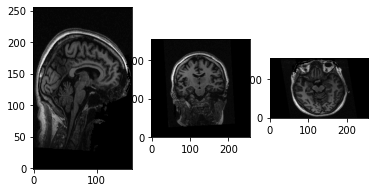

In [13]:
print(data.shape)
i, j, k = np.array(data.shape) // 2
fig, axes = plt.subplots(1, 3)
axes[0].imshow(data[i,:,:].T, cmap='Greys_r', origin='lower')
axes[1].imshow(data[:,j,:].T, cmap='Greys_r', origin='lower')
_ = axes[2].imshow(data[:,:,k].T, cmap='Greys_r', origin='lower')

Each location in the image data array is a *voxel* (pixel with a volume), and can be referred to with *voxel coordinates* (array indices).

This is a natural way to describe a block of data, but is practically meaningless with regard to anatomy.

NiBabel has a basic viewer that scales voxels to reflect their size and labels orientations.

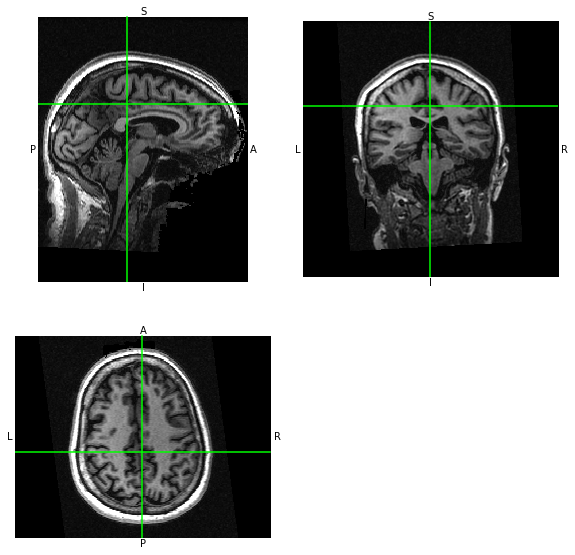

In [14]:
_ = t1w.orthoview()  # Requires matplotlib, occasionally glitchy in OSX setups

The crosshair is focused at the origin $(0, 0, 0)$.

All of this information is encoded in the affine:

In [15]:
print(affine)

[[ 9.99131918e-01 -5.16291820e-02  1.25127016e-02 -1.25263863e+02]
 [ 4.07721959e-02  1.29202044e+00 -9.81179178e-02 -7.31330109e+01]
 [-8.54506902e-03  1.28044292e-01  9.95096147e-01 -1.77554291e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Affine transforms

The affine is a 4 x 4 numpy array. This describes the transformation from the voxel space (indices $(i, j, k)$) to a *reference* space (coordinates $(x, y, z)$). These coordinates are, by convention, distance in mm *right*, *anterior* and *superior* of an origin\*.

$$
    \begin{bmatrix}
    x\\
    y\\
    z\\
    1\\
    \end{bmatrix} =
    \mathbf A
    \begin{bmatrix}
    i\\
    j\\
    k\\
    1\\
    \end{bmatrix} =\begin{bmatrix}
    m_{1,1} & m_{1,2} & m_{1,3} & a \\
    m_{2,1} & m_{2,2} & m_{2,3} & b \\
    m_{3,1} & m_{3,2} & m_{3,3} & c \\
    0 & 0 & 0 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
    i\\
    j\\
    k\\
    1\\
    \end{bmatrix}
$$

For an unmodified image, this reference space typically refers to an origin in the isocenter of the imaging magnet, and the directions right, anterior and superior are defined assuming a subject is lying in the scanner, face up.

![](https://nipy.org/nibabel/_images/localizer.png)

\* *If a file format uses an alternative convention, NiBabel converts on read/write, so affines are always RAS+.*

#### The affine as a series of transformations

<!--
<div style="float: left">
    <img src="https://nipy.org/nibabel/_images/illustrating_affine.png">
</div>
-->

![](https://nipy.org/nibabel/_images/illustrating_affine.png)

An affine transformation can be decomposed into translation, rotation, scaling (zooms) and shear transformations, applied right-to-left.

In [16]:
T, R, Z, S = transforms3d.affines.decompose44(affine)  # External library
print(f"Translation: {T}\nRotation:\n{R}\nZooms: {Z}\nMax shear: {np.abs(S).max()}")

Translation: [-125.26386261  -73.13301086 -177.55429077]
Rotation:
[[ 0.99913193 -0.03973383  0.01251451]
 [ 0.0407722   0.99433924 -0.09811785]
 [-0.00854507  0.09854292  0.99509611]]
Zooms: [0.99999999 1.2993759  1.00000002]
Max shear: 1.8087155968217092e-06


In [17]:
Tm, Rm, Zm, Sm = [np.eye(4) for _ in range(4)]
Tm[:3, 3] = T
Rm[:3, :3] = R
Zm[:3, :3] = np.diag(Z)
Sm[[0, 0, 1], [1, 2, 2]] = S
np.allclose(Tm @ Rm @ Zm @ Sm, affine)

True

NiBabel provides functions for extracting information from affines:

* Orientation (or axis codes) indicates the direction an axis encodes. If increasing index along an axis moves to the right or left, the axis is coded "R" or "L", respectively.
* Voxel sizes (or zooms)
* Obliquity measures the amount of rotation from "canonical" axes.

In [18]:
print("Orientation:", nb.aff2axcodes(affine))
print("Zooms:", nb.affines.voxel_sizes(affine))
print("Obliquity:", nb.affines.obliquity(affine))

Orientation: ('R', 'A', 'S')
Zooms: [0.99999999 1.2993759  1.00000002]
Obliquity: [0.04167007 0.10645293 0.09907456]


You can also use it to answer specific questions. For instance, the inverse affine allows you to calculate indices from RAS coordinates and look up the image intensity value at that location.

In [19]:
i, j, k, _ = np.linalg.pinv(affine) @ [0, 0, 0, 1]
print(f"Center: ({int(i)}, {int(j)}, {int(k)})")
print(f"Value: ", data[int(i), int(j), int(k)])

Center: (126, 65, 171)
Value:  312.0


#### Don't Panic

<div style="float: right"><img src="https://nipy.org/nibabel/_static/reggie.png"></div>

If you didn't follow all of the above, that's okay. Here are the important points:

1. Affines provide the spatial interpretation of the data.
2. NiBabel has some useful methods for working with them.

You'll go over this again with Noah Benson in [Introduction to the Geometry and Structure of the Human Brain](https://neurohackademy.org/course/introduction-to-the-geometry-and-structure-of-the-human-brain/).

Matthew Brett's [Coordinate systems and affines](https://nipy.org/nibabel/coordinate_systems.html) tutorial is an excellent resource.

### Image headers

The image header is specific to each file format. Minimally, it contains information to construct the data and affine arrays, but some methods are useful beyond that. 

* `get_zooms()` method returns voxel sizes. If the data is 4D, then repetition time is included as a temporal zoom.
* `get_data_dtype()` returns the numpy data type in which the image data is stored (or will be stored when the image is saved).

In [20]:
print(bold.header.get_zooms())
print(bold.header.get_data_dtype())

(4.0, 4.0, 3.999975, 2.5)
int16


For images with fixed header structures, header fields are exposed through a `dict`-like interface.

In [21]:
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 156 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        1.        1.2993759 1.        0.009668  0.        0.
 0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL5.0'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.049235623
quatern_c       : 0.005271982
quatern_d       : 0.020155331
qoffset_x       : -125.26386
qoffset_y 

In [22]:
print(header['descrip'])

b'FSL5.0'


The MGH header is similarly accessible, but its structure is quite different:

In [23]:
mghheader = nb.load('/tmp/img.mgz').header
print(mghheader)

<class 'nibabel.freesurfer.mghformat.MGHHeader'> object, endian='>'
version      : 1
dims         : [256 156 256   1]
type         : 3
dof          : 0
goodRASFlag  : 1
delta        : [1.        1.2993759 1.       ]
Mdc          : [[ 0.9991319   0.0407722  -0.00854507]
 [-0.03973383  0.9943392   0.09854292]
 [ 0.0125127  -0.09811792  0.99509615]]
Pxyz_c       : [  0.1995725  20.30433   -41.2883   ]
tr           : 0.0
flip_angle   : 0.0
te           : 0.0
ti           : 0.0
fov          : 0.0


In [24]:
print(mghheader['Pxyz_c'])
print(mghheader.get_zooms())
print(mghheader.get_data_dtype())

[  0.1995725  20.30433   -41.2883   ]
(1.0, 1.2993759, 1.0)
>f4


Other formats use text key-value pairs (PAR/REC, BRIK/HEAD) or keys in NetCDF (MINC 1.0) or HDF5 (MINC 2.0) containers, and their values are accessible by other means.

Often, we're not particularly interested in the header, or even the affine. But it's important to know they're there and, especially, to remember to copy them when making new images, so that derivatives stay aligned with the original image.

### Creating new images

Reading data will only take you so far. In many cases, you will want to use the image to compute a new image in the same space. Such a function might take the form:

```Python
def my_function(image):
    orig_data = image.get_fdata()
    new_data = some_operation_on(orig_data)
    return image.__class__(new_data, affine=image.affine, header=image.header)
```

Note the `image.__class__` ensures that the output image is the same type as the input. If your operation requires specific format features, you might use a specific class like `nb.Nifti1Image`.

For example, perhaps we want to save space and rescale our T1w image to an unsigned byte:

In [25]:
def rescale(img):
    data = img.get_fdata()
    rescaled = ((data - data.min()) * 255. / (data.max() - data.min())).astype(np.uint8)
    
    rescaled_img = img.__class__(rescaled, affine=img.affine, header=img.header)
    
    rescaled_img.header.set_data_dtype('uint8')  # Ensure data is saved as this type
    return rescaled_img

rescaled_t1w = rescale(t1w)
rescaled_t1w.to_filename('/tmp/rescaled_t1w.nii.gz')

## Data objects - Arrays and Array Proxies

Recall that the spatial image contains data, affine and header objects. When creating a new image, the `data` array is typically an array.

In [26]:
array_img = nb.Nifti1Image(np.arange(244, 268).reshape(2, 3, 4), affine=np.diag([2, 2, 2, 1]))
print(array_img.dataobj)

[[[244 245 246 247]
  [248 249 250 251]
  [252 253 254 255]]

 [[256 257 258 259]
  [260 261 262 263]
  [264 265 266 267]]]


When loading a file, an `ArrayProxy` is used for most image types.

In [27]:
array_img.to_filename('/tmp/array_img.nii')
proxy_img = nb.load('/tmp/array_img.nii')
print(proxy_img.dataobj)

An array proxy is an object that knows how to access data, but does not read it until requested. The usual way to request data is `get_fdata()`, which returns all data as floating point:

In [28]:
proxy_img.get_fdata(dtype=np.float32)  # The default is float64, but you can choose any floating point type.

memmap([[[244., 245., 246., 247.],
         [248., 249., 250., 251.],
         [252., 253., 254., 255.]],

        [[256., 257., 258., 259.],
         [260., 261., 262., 263.],
         [264., 265., 266., 267.]]], dtype=float32)

`get_fdata()` provides a very predictable interface. When you need more control, you'll want to work with the `ArrayProxy` directly.

### Converting array proxies to arrays

Array proxies are designed to be one step away from a numpy array:

In [29]:
arr = np.asanyarray(proxy_img.dataobj)  # array will create a copy; asarray passes through arrays; asanyarray passes subclasses like memmap through
print(arr.dtype)
arr

int64


memmap([[[244, 245, 246, 247],
         [248, 249, 250, 251],
         [252, 253, 254, 255]],

        [[256, 257, 258, 259],
         [260, 261, 262, 263],
         [264, 265, 266, 267]]])

Memory maps are arrays that remain on disk, rather than in RAM. This is only possible with uncompressed images.

We can also cast to any type we please, however unwisely.

In [30]:
print(np.uint8(proxy_img.dataobj))       # Values over 255 will be truncated
print(np.complex256(proxy_img.dataobj))  # A life less ordinal

[[[244 245 246 247]
  [248 249 250 251]
  [252 253 254 255]]

 [[  0   1   2   3]
  [  4   5   6   7]
  [  8   9  10  11]]]
[[[244.+0.j 245.+0.j 246.+0.j 247.+0.j]
  [248.+0.j 249.+0.j 250.+0.j 251.+0.j]
  [252.+0.j 253.+0.j 254.+0.j 255.+0.j]]

 [[256.+0.j 257.+0.j 258.+0.j 259.+0.j]
  [260.+0.j 261.+0.j 262.+0.j 263.+0.j]
  [264.+0.j 265.+0.j 266.+0.j 267.+0.j]]]


### Indexing and slicing array proxies

One of the primary motivations for an array proxy is to avoid loading data unnecessarily. Accessing the array proxy with array indices or slices will return the requested values without loading other data:

In [31]:
print(proxy_img.dataobj[0])
print(proxy_img.dataobj[..., 1:3])

[[244 245 246 247]
 [248 249 250 251]
 [252 253 254 255]]
[[[245 246]
  [249 250]
  [253 254]]

 [[257 258]
  [261 262]
  [265 266]]]


For example, this is useful for fetching a single volume from a BOLD series:

In [32]:
vol0 = bold.dataobj[..., 0]
vol0.shape

(64, 64, 30)

Slicing works with compressed data, as well. Install the [indexed-gzip](https://pypi.org/project/indexed-gzip/) package for significant speedups with gzipped files.

### Scaling array proxies

Several image types, including NIfTI, have a slope and intercept (scaling factors) in the header that allows them to extend the data range and/or precision beyond those of the on-disk type.

For example `uint16` can take the values 0-65535. If a BOLD series includes values from 500-2000, we can calculate a slope that will allow us to utilize the 16 bits of precision to encode our desired values.

0.02288818359375 500


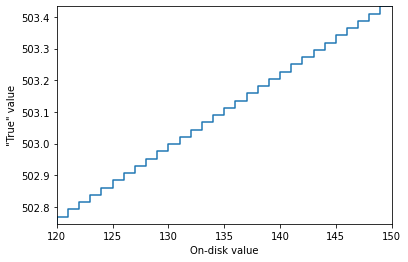

In [33]:
pr = (500, 2000)                            # Plausible range
nbits = 16                                  # 16-bits of precision
scl_slope = (pr[1] - pr[0]) / (2 ** nbits)  # Resolvable difference
scl_inter = pr[0]                           # Minimum value
print(scl_slope, scl_inter)
"Saving space by collapsing plotting into one line."; x = np.arange(2 ** nbits); plt.step(x, x * scl_slope + scl_inter); vlim = np.array([120, 150]); plt.xlim(vlim); plt.ylim(vlim * scl_slope + scl_inter); plt.xlabel("On-disk value"); plt.ylabel('"True" value'); _ = plt.show();

Let's create an image from some random values in our plausible range:

In [34]:
float_img = nb.Nifti1Image(np.random.default_rng().uniform(500, 2000, (2, 3, 4)),  # 64-bit float
                           affine=np.diag([2, 2, 2, 1]))
print(float_img.get_fdata())

[[[ 840.39886182 1081.43237313  835.40125694  982.33174656]
  [1573.21571784 1261.74029839  600.53166939 1131.41563477]
  [1638.7430394  1913.94671681 1364.22730446  711.51449619]]

 [[ 642.17083878 1226.3384657  1562.95952987 1962.86543456]
  [1148.47532746 1302.16166916  877.44302527 1921.37256987]
  [1301.64831329 1167.99390276 1585.47466315 1442.73636725]]]


Save as `uint16` and check its values:

In [35]:
float_img.header.set_data_dtype(np.uint16)
float_img.to_filename("/tmp/uint16_img.nii")

uint16_img = nb.load("/tmp/uint16_img.nii")
print(uint16_img.get_fdata())

[[[ 840.40302254 1081.43848911  835.3931435   982.32187811]
  [1573.21736212 1261.73177083  600.53167725 1131.41255221]
  [1638.74075933 1913.95150033 1364.23680624  711.51816763]]

 [[ 642.16980053 1226.33001149 1562.96893737 1962.86538155]
  [1148.47940154 1302.16419709  877.44702439 1921.37277342]
  [1301.64450009 1167.9992207  1585.48221122 1442.73184046]]]


We clearly lost some precision...

In [36]:
np.max(np.abs(float_img.get_fdata() - uint16_img.get_fdata()))

0.009868452619912205

But what's going on?

The `ArrayProxy` keeps track of scaling factors:

In [37]:
print(f"Slope: {uint16_img.dataobj.slope}; Intercept: {uint16_img.dataobj.inter}")
print(uint16_img.dataobj.get_unscaled())

Slope: 0.020787879824638367; Intercept: 600.5316772460938
[[[11539 23134 11298 18366]
  [46791 31807     0 25538]
  [49943 63182 36738  5339]]

 [[ 2003 30104 46298 65535]
  [26359 33752 13321 63539]
  [33727 27298 47381 40514]]]


The scaling is done automatically when the data is accessed, by slice or whole.

In [38]:
print(np.asanyarray(uint16_img.dataobj))
print(uint16_img.dataobj[0, 0, 0])

[[[ 840.40302254 1081.43848911  835.3931435   982.32187811]
  [1573.21736212 1261.73177083  600.53167725 1131.41255221]
  [1638.74075933 1913.95150033 1364.23680624  711.51816763]]

 [[ 642.16980053 1226.33001149 1562.96893737 1962.86538155]
  [1148.47940154 1302.16419709  877.44702439 1921.37277342]
  [1301.64450009 1167.9992207  1585.48221122 1442.73184046]]]
840.4030225425959


The `ArrayProxy` guarantees that the data has the intended *value*, but the *type* can vary based on the on-disk type and the values of scaling factors.

In [39]:
print(proxy_img.dataobj[0, 0, 0].dtype)   # Our earlier integer image
print(uint16_img.dataobj[0, 0, 0].dtype)

int64
float64


`get_fdata()` sweeps these details under the rug and always gives you the same type.

### Don't Panic

<div style="float: right"><img src="https://nipy.org/nibabel/_static/reggie.png"></div>

If you didn't follow all of the above, that's okay. Here are the important points:

1. When in doubt, use `img.get_fdata()` will fetch all of the data, and it will always be a float
2. `img.dataobj` exists if you want to load only some data or control the data type
3. Both methods transparently scale data when needed

In the NiBabel docs, [The image data array](https://nipy.org/nibabel/nibabel_images.html#the-image-data-array) gives you an overview of both methods, and [Images and memory](https://nipy.org/nibabel/images_and_memory.html) has even more details.

## Slicing images

Slicing array proxies is nice. Wouldn't it be nicer to keep track of the affine and header?

The `slicer` attribute provides an interface that allows you to apply slices to an image, and updates the affine to ensure that the spatial information matches.

Consider the T1-weighted image from earlier:

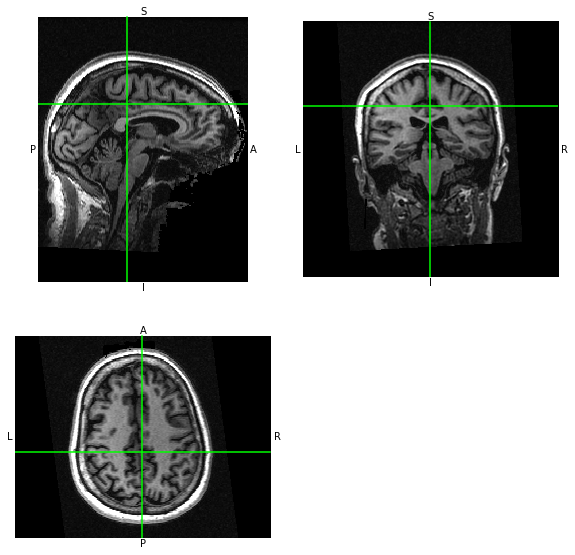

In [40]:
_ = t1w.orthoview()

We can use the slicer to crop unneeded voxels in the left-right and inferior-superior directions:

<OrthoSlicer3D: (176, 156, 176)>

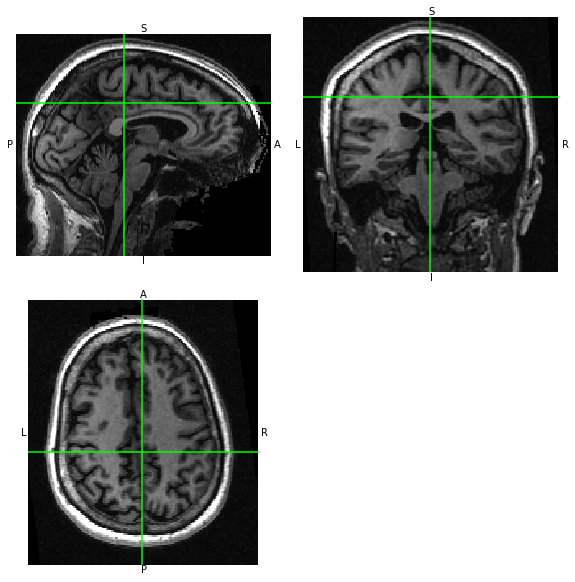

In [41]:
cropped = t1w.slicer[40:216, :, 50:226]
cropped.orthoview()

Note the origin crosshair points to the same structure. The affines now differ in translation:

In [42]:
print(cropped.affine - t1w.affine)

[[ 0.          0.          0.         40.5909118 ]
 [ 0.          0.          0.         -3.27500805]
 [ 0.          0.          0.         49.41300459]
 [ 0.          0.          0.          0.        ]]


You can even downsample an image, and the zooms will reflect the increased distance between voxels.

(4.0, 5.1975036, 4.0)


<OrthoSlicer3D: (44, 39, 44)>

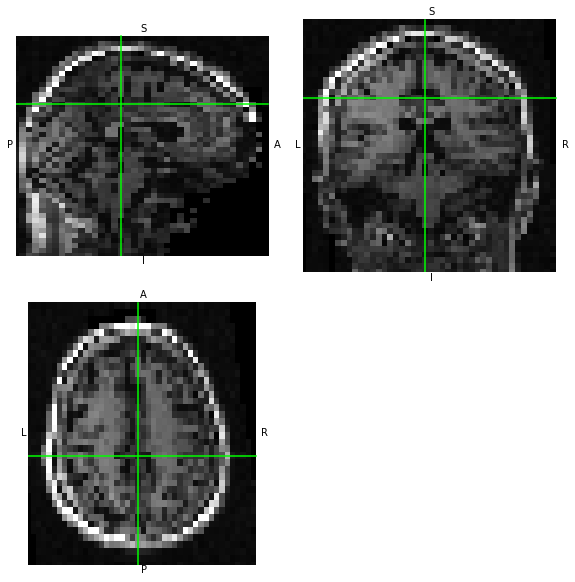

In [43]:
cheap_downsample = cropped.slicer[2::4, 2::4, 2::4]
print(cheap_downsample.header.get_zooms())
cheap_downsample.orthoview()

Note that this is a bad idea in *most* circumstances because it induces aliasing.

The better approach would be to anti-alias and then slice:

<OrthoSlicer3D: (44, 39, 44)>

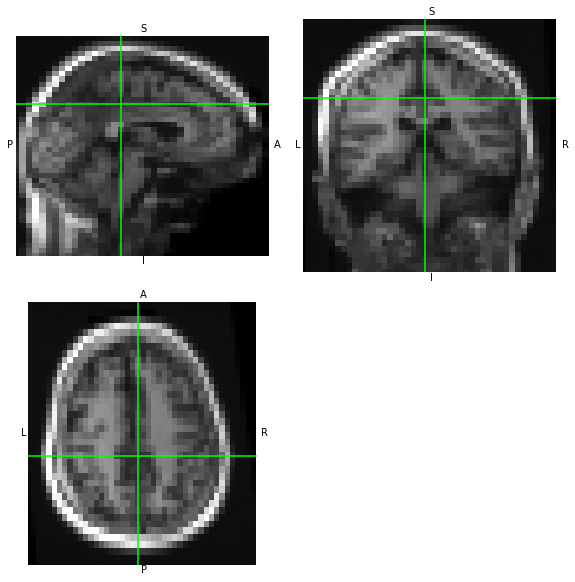

In [44]:
def blur(img, sigma):  # Isotropic in voxel space, not world space
    return img.__class__(ndi.gaussian_filter(img.dataobj, sigma), img.affine, img.header)

better_downsample = blur(cropped, sigma=1.5).slicer[2::4, 2::4, 2::4]
better_downsample.orthoview()

For non-spatial dimensions, slices or indices may be used to select one or more volumes.

In [45]:
tp15 = bold.slicer[..., :5]
tp1 = bold.slicer[..., 0]
print(f"BOLD shape: {bold.shape}; Zooms: {bold.header.get_zooms()}")
print(f"Time pts 1-5 shape: {tp15.shape}; Zooms: {tp15.header.get_zooms()}")
print(f"Time pt 1 shape: {tp1.shape}; Zooms: {tp1.header.get_zooms()}")
np.array_equal(tp15.get_fdata(), bold.dataobj[..., :5])

BOLD shape: (64, 64, 30, 184); Zooms: (4.0, 4.0, 3.999975, 2.5)
Time pts 1-5 shape: (64, 64, 30, 5); Zooms: (4.0, 4.0, 3.999975, 2.5)
Time pt 1 shape: (64, 64, 30); Zooms: (4.0, 4.0, 3.999975)


True

Aliasing considerations apply to time series as well, so be careful with down-sampling here, too.

<center>Break!</center>

## Surface Images

Although the scanner samples data in three dimensions, some brain structures are better represented as a convoluted sheet than a volume. Data may be usefully resampled onto a cortical sheet, but in the process, it loses the intrinsic geometry of a 3D array.

To represent data on a surface, you need the following structures:

1. The surface *mesh*
   1. Vertices: a list of coordinates in world space
   1. Faces: a list of 3-tuples of indices into the coordinate list
2. The *data* array: a 1D or 2D array of values or vectors at each vertex

Unlike spatial images, these components are frequently kept in separate files.

*Terminological note*: You are likely to encounter multiple names for each of these. *Vertices* may be called *coordinates* or a *point set*. *Faces* are often called *triangles*. When a data array is plotted on the surface, it might be called a *texture*.

### Image-specific interfaces

The two supported surface formats at present are GIFTI and FreeSurfer geometry files. Unlike spatial images, there is not yet a common interface for working with surface-based data.

FreeSurfer encodes a great deal of information in its directory structure and file names, allowing the necessary data arrays to have relatively simple formats.

GIFTI is more of an interchange format, and so has a rich metadata structure and can store different kinds of data.

#### Surface meshes

To load a surface mesh in a FreeSurfer directory, use `nb.freesurfer.read_geometry`:

In [46]:
fs_verts, fs_faces, fs_meta = nb.freesurfer.read_geometry(data_dir / 'ds005-preproc/freesurfer/sub-01/surf/lh.pial', read_metadata=True)
print(fs_verts[:2])
print(fs_faces[:2])
pprint(fs_meta)

[[ -9.01226521 -96.7989502  -31.38132668]
 [ -9.62946892 -96.77184296 -31.43518829]]
[[0 1 3]
 [4 3 1]]
OrderedDict([('head', array([ 2,  0, 20], dtype=int32)),
             ('valid', '1  # volume info valid'),
             ('filename', '../mri/filled-pretess255.mgz'),
             ('volume', array([256, 256, 256])),
             ('voxelsize', array([1., 1., 1.])),
             ('xras', array([-0.99999994,  0.        ,  0.        ])),
             ('yras', array([ 0.        ,  0.        , -0.99999994])),
             ('zras', array([0.        , 0.99999994, 0.        ])),
             ('cras', array([-0.99998474, -5.00001526, -1.00003815]))])


NiBabel does not have any viewer for surfaces, but Nilearn has plotting utilities:

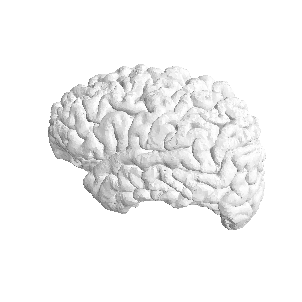

In [47]:
_ = nlp.plot_surf((fs_verts, fs_faces))

Let's do the same thing with GIFTI. Here, the file-level metadata is minimal:

In [48]:
gii_pial = nb.load(data_dir / 'ds005-preproc/fmriprep/sub-01/anat/sub-01_hemi-L_pial.surf.gii')
pprint(gii_pial.meta.metadata)  # .meta maps onto the XML object, its .metadata property exposes a Python dict

{'Date': 'Mon Jan 13 17:14:05 2020',
 'UserName': 'root',
 'gifticlib-version': 'gifti library version 1.09, 28 June, 2010'}


The vertices and faces are stored as separate data arrays, each with their own metadata. These can be queried by NIfTI *intent code*:

In [49]:
pointset_darray = gii_pial.get_arrays_from_intent('pointset')[0]
triangle_darray = gii_pial.get_arrays_from_intent('triangle')[0]
pprint(pointset_darray.meta.metadata)
pprint(triangle_darray.meta.metadata)

{'AnatomicalStructurePrimary': 'CortexLeft',
 'AnatomicalStructureSecondary': 'Pial',
 'GeometricType': 'Anatomical',
 'Name': '/out/freesurfer/sub-01/surf/lh.pial',
 'SurfaceCenterX': '-32.284454',
 'SurfaceCenterY': '-22.393669',
 'SurfaceCenterZ': '-2.683327',
 'VolGeomC_A': '0.000000',
 'VolGeomC_R': '0.000000',
 'VolGeomC_S': '0.000000',
 'VolGeomDepth': '256',
 'VolGeomHeight': '256',
 'VolGeomWidth': '256',
 'VolGeomX_A': '0.000000',
 'VolGeomX_R': '-1.000000',
 'VolGeomX_S': '0.000000',
 'VolGeomXsize': '1.000000',
 'VolGeomY_A': '0.000000',
 'VolGeomY_R': '0.000000',
 'VolGeomY_S': '-1.000000',
 'VolGeomYsize': '1.000000',
 'VolGeomZ_A': '1.000000',
 'VolGeomZ_R': '0.000000',
 'VolGeomZ_S': '0.000000',
 'VolGeomZsize': '1.000000'}
{'Name': '/out/freesurfer/sub-01/surf/lh.pial', 'TopologicalType': 'Closed'}


The actual values are stored as the `.data` attribute:

In [50]:
gii_verts, gii_faces = pointset_darray.data, triangle_darray.data
print(gii_verts[:2])
print(gii_faces[:2])

[[ -10.000125 -101.81076   -32.395775]
 [ -10.617342 -101.78375   -32.44954 ]]
[[0 1 3]
 [4 3 1]]


This API can be cumbersome, if all you want is the NumPy arrays. Thanks to a project started at Neurohackademy 2019, the `agg_data()` (aggregate data) method will find the requested data array(s) and return just the data:

[[ -10.000125 -101.81076   -32.395775]
 [ -10.617342 -101.78375   -32.44954 ]]
[[0 1 3]
 [4 3 1]]


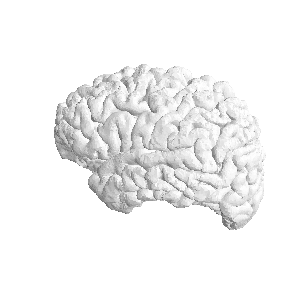

In [51]:
gii_verts, gii_faces = gii_pial.agg_data(('pointset', 'triangle'))
print(gii_verts[:2])
print(gii_faces[:2])
_ = nlp.plot_surf((gii_verts, gii_faces))

#### Surface-sampled data

For data sampled to the surface, FreeSurfer has a few data types:

In [52]:
# Morphometry
curv = nb.freesurfer.read_morph_data(data_dir / 'ds005-preproc/freesurfer/sub-01/surf/lh.curv')
# Annotations
labels, color_table, names = nb.freesurfer.read_annot(data_dir / 'ds005-preproc/freesurfer/sub-01/label/lh.aparc.annot')
# MGH files...
mgh = nb.load(data_dir / 'ds005-preproc/freesurfer/sub-01/surf/lh.w-g.pct.mgh')
print(curv.shape)
print(labels.shape)
print(mgh.shape)

(126142,)
(126142,)
(126142, 1, 1)


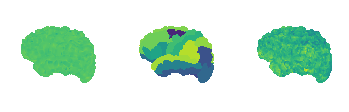

In [53]:
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'})
_ = nlp.plot_surf((fs_verts, fs_faces), curv, axes=axes[0])
_ = nlp.plot_surf((fs_verts, fs_faces), labels, axes=axes[1])
_ = nlp.plot_surf((fs_verts, fs_faces), mgh.get_fdata(), axes=axes[2])

GIFTIs will be GIFTIs. This one is a BOLD series sampled to the `fsaverage5` surface:

In [54]:
bold_gii = nb.load(data_dir / 'ds005-preproc/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-fsaverage5_hemi-L_bold.func.gii')

Each time point is an individual data array with intent `NIFTI_INTENT_TIME_SERIES`. `agg_data()` will aggregate these into a single array.

In [55]:
data = bold_gii.agg_data('time series')
data.shape

(10242, 240)

We can plot the mean BOLD signal. This time we will use a FreeSurfer surface, which Nilearn knows what to do with:

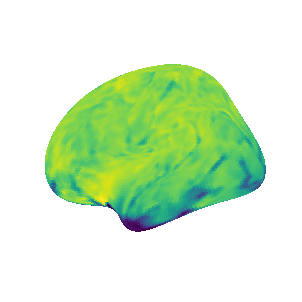

In [56]:
_ = nlp.plot_surf(str(data_dir / 'ds005-preproc/freesurfer/fsaverage5/surf/lh.inflated'), data.mean(axis=1))

### Don't Panic

<div style="float: right"><img src="https://nipy.org/nibabel/_static/reggie.png"></div>

If you didn't follow all of the above, that's okay. Here are the important points:

1. Practical considerations make dealing with surfaces a multi-file affair
2. The data structures are common (vertices, faces, per-vertex data arrays), but the arrangement can vary
3. For working with FreeSurfer files, learn to traverse the directory and identify file types
4. For working with GIFTI, learn to query the file for its contents

Hopefully next year, we'll be able to talk about a common interface that will simplify things.

## CIFTI-2

<div style="float: right">
    <div>
        <img src="https://www.ncbi.nlm.nih.gov/pmc/articles/instance/6172654/bin/nihms-990058-f0001.jpg"><br/>
        <span style="font-size: small">From Glasser, et al., 2016. doi:<a href="https://doi.org/10.1038/nn.4361">10.1038/nn.4361</a></span>
    </div>
</div>

CIFTI-2 is a file format intended to cover many use cases for connectivity analysis.

Files have 2-3 dimensions and each dimension is described by one of 5 types of axis.

* Brain models: each row/column is a voxel or vertex
* Parcels: each row/column is a group of voxels and/or vertices
* Scalars: each row/column has a unique name
* Labels: each row/column has a unique name and label table
* Series: each row/column is a point in a series (typically time series), which increases monotonically

For example, a "parcellated dense connectivity" CIFTI-2 file has two dimensions, indexed by a brain models axis and a parcels axis, respectively. The interpretation is "connectivity from parcels to vertices and/or voxels".

<div style="float: right">
    <img src="images/cifti-xml.png">
</div>

On disk, the file is a NIfTI-2 file with an alternative XML header as an extension, schematized here.

NiBabel loads a header that closely mirrors this structure, and makes the NIfTI-2 header accessible as a `nifti_header` attribute.

In [57]:
cifti = nb.load(data_dir / 'ds005-preproc/fmriprep/sub-01/func/sub-01_task-mixedgamblestask_run-1_space-fsLR_den-91k_bold.dtseries.nii')
cifti_data = cifti.get_fdata(dtype=np.float32)
cifti_hdr = cifti.header
nifti_hdr = cifti.nifti_header

The `Cifti2Header` is useful if you're familiar with the XML structure and need to fetch an exact value or have fine control over the header that is written.

In [58]:
bm0 = next(cifti_hdr.matrix[1].brain_models)
print(bm0.voxel_indices_ijk)
print(list(bm0.vertex_indices)[:20])

None
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


Most of the time, the `Axis` format will be more useful:

In [59]:
axes = [cifti_hdr.get_axis(i) for i in range(cifti.ndim)]
axes

The simplest way to get a handle on CIFTI-2 data is to use it. Let's take an axis and a data block and repackage the voxels as a regular NIfTI-1 image:

In [60]:
def volume_from_cifti(data, axis):
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    data = data.T[axis.volume_mask]                          # Assume brainmodels axis is last, move it to front
    volmask = axis.volume_mask                               # Which indices on this axis are for voxels?
    vox_indices = tuple(axis.voxel[axis.volume_mask].T)      # ([x0, x1, ...], [y0, ...], [z0, ...])
    vol_data = np.zeros(axis.volume_shape + data.shape[1:],  # Volume + any extra dimensions
                        dtype=data.dtype)
    vol_data[vox_indices] = data                             # "Fancy indexing"
    return nb.Nifti1Image(vol_data, axis.affine)             # Add affine for spatial interpretation

<OrthoSlicer3D: (91, 109, 91, 240)>

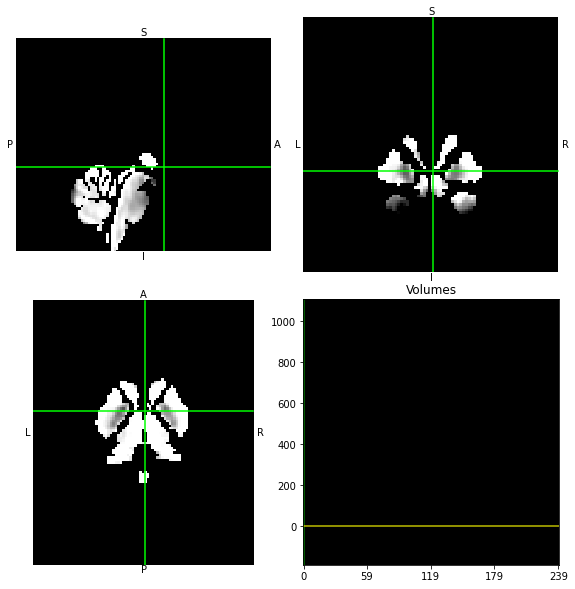

In [61]:
volume_from_cifti(cifti_data, axes[1]).orthoview()

Now we can extract the values on a surface vertex. This time, as a simple numpy array:

In [62]:
def surf_data_from_cifti(data, axis, surf_name):
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    for name, data_indices, model in axis.iter_structures():  # Iterates over volumetric and surface structures
        if name == surf_name:                                 # Just looking for a surface
            data = data.T[data_indices]                       # Assume brainmodels axis is last, move it to front
            vtx_indices = model.vertex                        # Generally 1-N, except medial wall vertices
            surf_data = np.zeros((vtx_indices.max() + 1,) + data.shape[1:], dtype=data.dtype)
            surf_data[vtx_indices] = data
            return surf_data
    raise ValueError(f"No structure named {surf_name}")

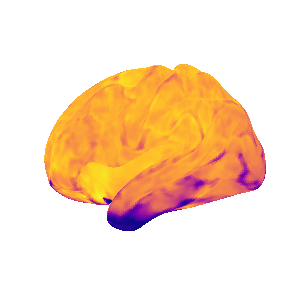

In [63]:
_ = nlp.plot_surf(str(data_dir / "conte69/Conte69.L.inflated.32k_fs_LR.surf.gii"),
                  surf_data_from_cifti(cifti_data, axes[1], 'CIFTI_STRUCTURE_CORTEX_LEFT').mean(axis=1),
                  cmap='plasma')

Finally, combine into a function that will break a CIFTI-2 matrix into a volume and two surface components:

In [64]:
def decompose_cifti(img):
    data = img.get_fdata(dtype=np.float32)
    brain_models = img.header.get_axis(1)  # Assume we know this
    return (volume_from_cifti(data, brain_models),
            surf_data_from_cifti(data, brain_models, "CIFTI_STRUCTURE_CORTEX_LEFT"),
            surf_data_from_cifti(data, brain_models, "CIFTI_STRUCTURE_CORTEX_RIGHT"))

In [65]:
vol, left, right = decompose_cifti(cifti)
print(vol.shape, left.shape, right.shape)

(91, 109, 91, 240) (32492, 240) (32492, 240)


## Tractography

<div style="float: right">
    <div>
        <img src="images/streamlines.png"><br/>
        <span style="font-size: small">From <a href="https://dipy.org/documentation/1.1.1./examples_built/streamline_tools/">DIPY documentation</a></span>
    </div>
</div>

Diffusion MRI uses estimates of the directional flow of water to detect white matter tracts. These tracts are represented as a series of points in world space.

NiBabel represents tractogram files as a collection of these things:

1. A *tractogram*, which is:
   1. A set of *streamlines*: each streamline is a series of coordinates describing a path
   1. Streamline-level data: a set of data arrays associated with each streamline
   1. Point-level data: a set of data arrays associated with each point of each streamline
1. An *affine* matrix: 4x4 array relating voxel coordinates of a reference image and world coordinates
1. File-level metadata: a format-specific header

Files of this type are considered `TractogramFile`s. Like `SpatialImage`, the goal is to provide a uniform interface where possible.

The two currently-supported file types are TCK (MRtrix) and TRK (TrackVis). We will load some very small ones that were created for testing:

In [66]:
tck = nb.streamlines.load(Path(nb.testing.data_path) / 'standard.tck')
trk = nb.streamlines.load(Path(nb.testing.data_path) / 'complex.trk')

Like a spatial image, printing the tractogram file gives an overview:

In [67]:
print(trk)

MAGIC NUMBER: TRACK
v.2
dim: [1 1 1]
voxel_sizes: [1. 1. 1.]
origin: [0. 0. 0.]
nb_scalars: 4
scalar_names:
  colors 3
  fa
nb_properties: 5
property_names:
  mean_colors 3
  mean_curvature
  mean_torsion
vox_to_world:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
voxel_order: RAS
image_orientation_patient: [0. 0. 0. 0. 0. 0.]
pad1: 
pad2: 
invert_x: 
invert_y: 
invert_z: 
swap_xy: 
swap_yz: 
swap_zx: 
n_count: 3
hdr_size: 1000


### The streamlines API

The overall API is as follows:

In [68]:
# File-level
tractogram = trk.tractogram
trk_affine = trk.affine      # Describes relation between voxels and coordinates in an associated image
trk_header = trk.header

# All streamlines
streamlines = tractogram.streamlines
data_per_point = tractogram.data_per_point
data_per_streamline = tractogram.data_per_streamline

# One streamline at a time
tractogram_item = tractogram[2]                        # Most to look at
streamline_coords = tractogram_item.streamline
streamline_data = tractogram_item.data_for_streamline
point_data = tractogram_item.data_for_points

#### A single streamline

When looking at an individual streamline, the objects are familiar: NumPy arrays and Python dictionaries.

In [69]:
print(streamline_coords)
pprint(streamline_data)
pprint(point_data)

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]
 [12. 13. 14.]]
{'mean_colors': array([0., 0., 1.], dtype=float32),
 'mean_curvature': array([3.11], dtype=float32),
 'mean_torsion': array([3.22], dtype=float32)}
{'colors': array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32),
 'fa': array([[0.5],
       [0.6],
       [0.6],
       [0.7],
       [0.8]], dtype=float32)}


#### All streamlines

When looking at all streamlines, the objects are custom. These deal with issues arising from the fact that each streamline may have a different number of coordinates, so N-dimensional arrays are not appropriate.

In [70]:
print(streamlines)
print(data_per_streamline)
print(data_per_point)

ArraySequence([array([[0., 1., 2.]], dtype=float32), array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32), array([[ 0.,  1.,  2.],
       [ 3.,  4.,  5.],
       [ 6.,  7.,  8.],
       [ 9., 10., 11.],
       [12., 13., 14.]], dtype=float32)])


The dictionaries operate like normal dictionaries, providing NumPy array and `ArraySequence` values.

In [71]:
print(data_per_streamline['mean_curvature'])
print(data_per_point['fa'])

[[1.11]
 [2.11]
 [3.11]]
ArraySequence([array([[0.2]], dtype=float32), array([[0.3],
       [0.4]], dtype=float32), array([[0.5],
       [0.6],
       [0.6],
       [0.7],
       [0.8]], dtype=float32)])


Each component is also indexable by integer:

In [72]:
print(streamlines[2])
pprint(dict(data_per_streamline[2])); print()  # For space
pprint(dict(data_per_point[2]))

[[ 0.  1.  2.]
 [ 3.  4.  5.]
 [ 6.  7.  8.]
 [ 9. 10. 11.]
 [12. 13. 14.]]
{'mean_colors': array([[0.],
       [0.],
       [1.]], dtype=float32),
 'mean_curvature': array([[3.11]], dtype=float32),
 'mean_torsion': array([[3.22]], dtype=float32)}

{'colors': ArraySequence([array([0., 0., 1.], dtype=float32), array([0., 0., 1.], dtype=float32), array([0., 0., 1.], dtype=float32), array([0., 0., 1.], dtype=float32), array([0., 0., 1.], dtype=float32)]),
 'fa': ArraySequence([array([0.5], dtype=float32), array([0.6], dtype=float32), array([0.6], dtype=float32), array([0.7], dtype=float32), array([0.8], dtype=float32)])}


As we can see, there are a few ways to get at the same data, based on whether you prefer to operate by streamline or by data element (such as `fa`).

# Summary

<div style="float: right"><img src="https://nipy.org/nibabel/_static/reggie.png"></div>

You made it!

## Learning objectives (reprise)

1. Be able to load and save different types of files in NiBabel
   * `nb.load`, `nb.save`, `img.to_filename()`, `img.to_bytes()`, `img.from_bytes()`
1. Become familiar with the `SpatialImage` API and identify its components
   * `img.get_fdata()`/`img.dataobj`
   * `img.affine`
   * `img.header`
1. Understand the differences between array and proxy images
   * Arrays are what it says on the tin.
   * Proxies conserve memory and automatically scale values
   * `get_fdata()` and `dataobj` provide tradeoffs between consistency and control
1. Acquire a passing familiarity with:
   * Surfaces: Meshes and per-vertex data, idiosyncratic
   * CIFTI-2: 2-3D NIfTI with some interesting axes; brainmodels can be decomposed into volume and surface components
   * Tractograms: Streamlines are paths in space, and data can be attached to the point or the path